Source:https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2023-12-18 05:18:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c06::cf, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   130MB/s    in 0.5s    

2023-12-18 05:18:53 (130 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
#extract files from zip to /tmp
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#create necessary directories to split data
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

# train directories
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# test directories
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')


In [6]:
#Check data shape
print('Training (Cat) :', len(os.listdir(train_cats_dir ) ))
print('Training (Dog) :', len(os.listdir(train_dogs_dir ) ))

print('Testing (Cat) :', len(os.listdir(test_cats_dir ) ))
print('Testing (Dog) :', len(os.listdir(test_dogs_dir ) ))
#Expected ouput
#1000
#1000
#500
#500

Training (Cat) : 1000
Training (Dog) : 1000
Testing (Cat) : 500
Testing (Dog) : 500


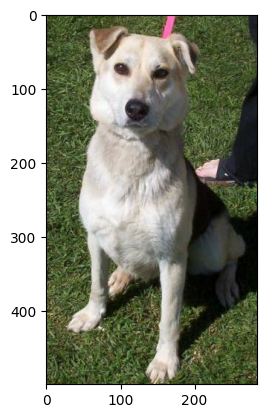

In [10]:
#See the cats and dogs
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#img_path=os.path.join(train_cats_dir, 'cat.40.jpg')
img_path=os.path.join(train_dogs_dir, 'dog.90.jpg')
img = mpimg.imread(img_path)
plt.imshow(img)

In [11]:
#Generate the data on the fly
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# reshape the image
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

#batch_size = 20 and target_size = 150x150
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
#define the model
import tensorflow as tf
model = tf.keras.models.Sequential([
    #Conv2D adds a convulation layer, 16: number of filters(https://lodev.org/cgtutor/filtering.html), (3,3) convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)), #images are 150x150 RGB(3)
    tf.keras.layers.MaxPooling2D(2,2),                    #MaxPooling2D will reduce the dimension
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), #another conv layer with 32 filters
    tf.keras.layers.MaxPooling2D(2,2),                    #another pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #another conv layer with 64 filters
    tf.keras.layers.MaxPooling2D(2,2),                    #anotehr pooling layers
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),        #512 neurons
    tf.keras.layers.Dense(1, activation='sigmoid')        #0 for cats and 1 for dogs (Binary classifier)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [13]:
#compile with RMSprop: RMS = Root Mean Squared
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [14]:
#Fit the model with 15 epochs
history = model.fit(train_generator,
                              validation_data=test_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 11s - loss: 0.7331 - accuracy: 0.5375 - val_loss: 0.6694 - val_accuracy: 0.6290 - 11s/epoch - 110ms/step
Epoch 2/15
100/100 - 5s - loss: 0.6581 - accuracy: 0.6320 - val_loss: 0.6258 - val_accuracy: 0.6450 - 5s/epoch - 45ms/step
Epoch 3/15
100/100 - 5s - loss: 0.6053 - accuracy: 0.6550 - val_loss: 0.6032 - val_accuracy: 0.6630 - 5s/epoch - 52ms/step
Epoch 4/15
100/100 - 6s - loss: 0.5587 - accuracy: 0.7105 - val_loss: 0.5585 - val_accuracy: 0.7090 - 6s/epoch - 58ms/step
Epoch 5/15
100/100 - 5s - loss: 0.5102 - accuracy: 0.7405 - val_loss: 0.5392 - val_accuracy: 0.7110 - 5s/epoch - 53ms/step
Epoch 6/15
100/100 - 5s - loss: 0.4632 - accuracy: 0.7785 - val_loss: 0.5410 - val_accuracy: 0.7320 - 5s/epoch - 45ms/step
Epoch 7/15
100/100 - 6s - loss: 0.4212 - accuracy: 0.8035 - val_loss: 0.5272 - val_accuracy: 0.7360 - 6s/epoch - 58ms/step
Epoch 8/15
100/100 - 4s - loss: 0.3478 - accuracy: 0.8425 - val_loss: 0.6405 - val_accuracy: 0.7120 - 4s/epoch - 45ms/step
Epoch 9/15
10

1/1 [==============================] - 0s 283ms/step


<ipython-input-15-5fdf8221a19d>:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()


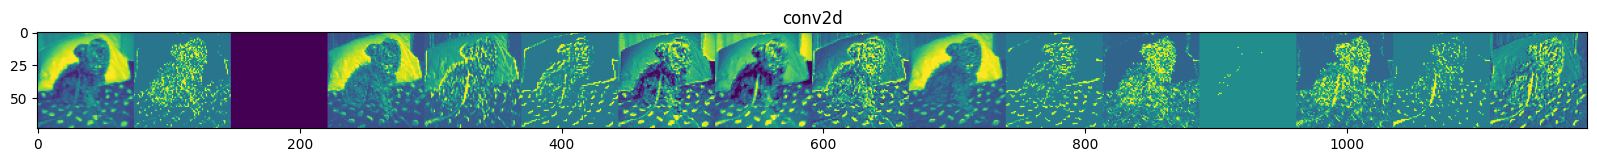

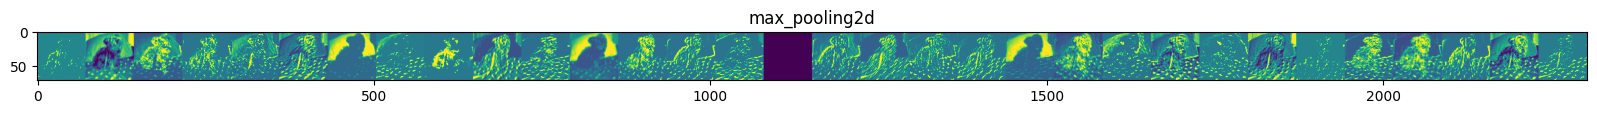

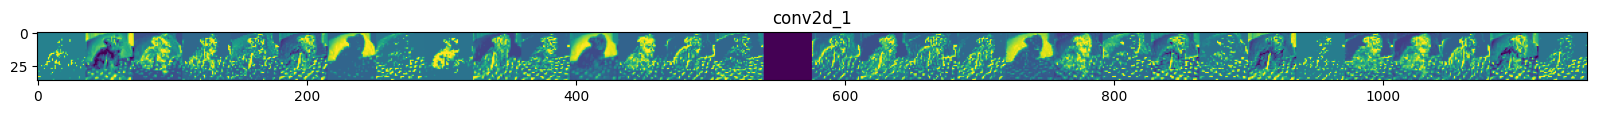

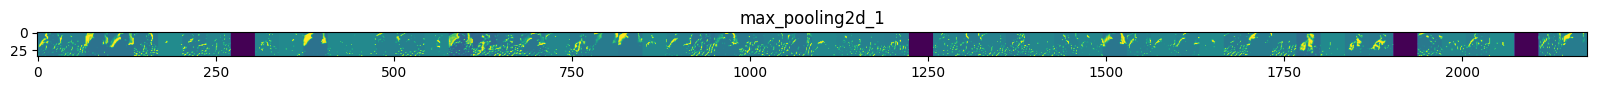

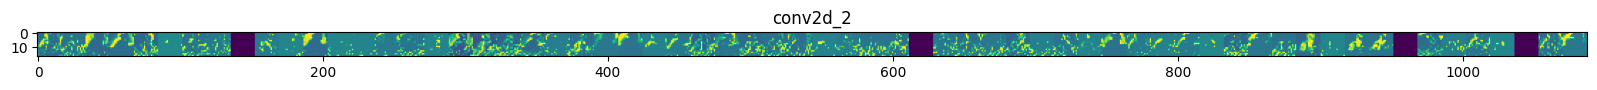

In [15]:
#The internal process
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img


successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

cat_img_files = [os.path.join(train_cats_dir, f) for f in ['cat.0.jpg','cat.10.jpg','cat.25.jpg','cat.40.jpg'
                                                            ,'cat.100.jpg']]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in ['dog.0.jpg','dog.10.jpg','dog.25.jpg','dog.40.jpg'
                                                            ,'dog.100.jpg']]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))

x   = img_to_array(img)
x   = x.reshape((1,) + x.shape)

x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]


for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    n_features = feature_map.shape[-1]
    size       = feature_map.shape[ 1]

    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [16]:
#Let's test with random images
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path='/content/' + fn       #Save the image to content folder
  img=image.load_img(path, target_size=(150, 150))    #load the image

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)    #predict the label for the image

  print(classes[0])     #Print the label, remember it will be either one or zero

  if classes[0]>0:
    print(fn + " is a dog")     #print human readable label

  else:
    print(fn + " is a cat")     #print human readable label

Saving kitten-4611189_640.jpg to kitten-4611189_640.jpg
1/1 [==============================] - 0s 67ms/step
[0.]
kitten-4611189_640.jpg is a cat
